In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import StringIO

# Get the data

## UVA

In [16]:
UVA_request = requests.get('https://avaa.tdata.fi/smear-services/smeardata.jsp?variables=UV_A&table=HYY_META&from=2008-01-01 00:00:00.971&to=2009-12-31 23:59:59.859&quality=CHECKED&averaging=NONE&type=NONE')

## Air pressure

In [19]:
p_request = requests.get('https://avaa.tdata.fi/smear-services/smeardata.jsp?variables=Pamb0&table=HYY_META&from=2008-01-01 00:00:00.131&to=2009-12-31 23:59:59.586&quality=CHECKED&averaging=NONE&type=NONE')

## Air temperature 67.2m

In [23]:
T_67m_request = requests.get('https://avaa.tdata.fi/smear-services/smeardata.jsp?variables=T672&table=HYY_META&from=2008-01-01 00:00:00.131&to=2009-12-31 23:59:59.586&quality=CHECKED&averaging=NONE&type=NONE')

## Air temperature 8.4m

In [28]:
T_8m_request = requests.get('https://avaa.tdata.fi/smear-services/smeardata.jsp?variables=T84&table=HYY_META&from=2008-01-01 00:00:00.131&to=2009-12-31 23:59:59.586&quality=CHECKED&averaging=NONE&type=NONE')

## Wind speed 67.2m


In [30]:
w_67m_request = requests.get('https://avaa.tdata.fi/smear-services/smeardata.jsp?variables=WSU672&table=HYY_META&from=2008-01-01 00:00:00.131&to=2009-12-31 23:59:59.586&quality=CHECKED&averaging=NONE&type=NONE')

## Wind speed 8.4m

In [33]:
w_8m_request = requests.get('https://avaa.tdata.fi/smear-services/smeardata.jsp?variables=WSU84&table=HYY_META&from=2008-01-01 00:00:00.131&to=2009-12-31 23:59:59.586&quality=CHECKED&averaging=NONE&type=NONE')

## Humidity 67.2m

In [36]:
RH_67m_request = requests.get('https://avaa.tdata.fi/smear-services/smeardata.jsp?variables=RHIRGA672&table=HYY_META&from=2008-01-01 00:00:00.131&to=2009-12-31 23:59:59.586&quality=CHECKED&averaging=NONE&type=NONE')

## Humidity 8.4m

In [38]:
RH_8m_request = requests.get('https://avaa.tdata.fi/smear-services/smeardata.jsp?variables=RHIRGA84&table=HYY_META&from=2008-01-01 00:00:00.131&to=2009-12-31 23:59:59.586&quality=CHECKED&averaging=NONE&type=NONE')

## O3 67.2m

In [49]:
O3_67m_request = requests.get('https://avaa.tdata.fi/smear-services/smeardata.jsp?variables=O3672&table=HYY_META&from=2008-01-01 00:00:00.131&to=2009-12-31 23:59:59.586&quality=CHECKED&averaging=NONE&type=NONE')

## O3 8.4m

In [51]:
O3_8m_request = requests.get('https://avaa.tdata.fi/smear-services/smeardata.jsp?variables=O384&table=HYY_META&from=2008-01-01 00:00:00.131&to=2009-12-31 23:59:59.586&quality=CHECKED&averaging=NONE&type=NONE')

## NOx 67.2m

In [53]:
NOx_67m_request = requests.get('https://avaa.tdata.fi/smear-services/smeardata.jsp?variables=NOx672&table=HYY_META&from=2008-01-01 00:00:00.131&to=2009-12-31 23:59:59.586&quality=CHECKED&averaging=NONE&type=NONE')

## NOx 8.4m

In [55]:
NOx_8m_request = requests.get('https://avaa.tdata.fi/smear-services/smeardata.jsp?variables=NOx84&table=HYY_META&from=2008-01-01 00:00:00.131&to=2009-12-31 23:59:59.586&quality=CHECKED&averaging=NONE&type=NONE')

## SO2 67.2m


In [59]:
SO2_67m_request = requests.get('https://avaa.tdata.fi/smear-services/smeardata.jsp?variables=SO2672&table=HYY_META&from=2008-01-01 00:00:00.131&to=2009-12-31 23:59:59.586&quality=CHECKED&averaging=NONE&type=NONE')

## SO2 8.4m

In [61]:
SO2_8m_request = requests.get('https://avaa.tdata.fi/smear-services/smeardata.jsp?variables=SO284&table=HYY_META&from=2008-01-01 00:00:00.131&to=2009-12-31 23:59:59.586&quality=CHECKED&averaging=NONE&type=NONE')

# Read data

In [65]:
def read_data(x):
    dateparse = lambda x: pd.datetime.strptime(x, '%Y %m %d %H %M %S')
    data = pd.read_csv(StringIO(x.text), parse_dates = {'Time': ['Year', 'Month', 'Day', 'Hour', 'Minute', 'Second']}, date_parser = dateparse)
    return data

In [74]:
parameters_request = [UVA_request, p_request, T_67m_request, T_8m_request, w_67m_request, w_8m_request, RH_67m_request, RH_8m_request]
[UVA, p, T_67m, T_8m, w_67m, w_8m, RH_67m, RH_8m] = [read_data(x) for x in parameters_request]

gas_request = [O3_67m_request, O3_8m_request, NOx_67m_request, NOx_8m_request, SO2_67m_request, SO2_8m_request]
[O3_67m, O3_8m, NOx_67m, NOx_8m, SO2_67m, SO2_8m] = [read_data(x) for x in gas_request]

## Join all data to one dataframe

In [170]:
df = pd.concat([
    df.set_index('Time') for df in [UVA, p, T_67m, T_8m, w_67m, w_8m, RH_67m, RH_8m, O3_67m, O3_8m, NOx_67m, NOx_8m, SO2_67m, SO2_8m]], axis=1, join='inner'
).reset_index()

In [172]:
Time = df.Time.values
df = df.drop('Time', axis = 1)
df.rename(columns = lambda x: x[9:], inplace = True) # Rename columns name

# Check data

In [173]:
df.head()

,UV_A,Pamb0,T672,T84,WSU672,WSU84,RHIRGA672,RHIRGA84,O3672,O384,NOx672,NOx84,SO2672,SO284
0,-0.001,1010.51,-2.22,-1.77,7.55,0.55,85.53,NaN,27.73,NaN,0.53,NaN,0.04,NaN
1,0.001,1010.55,-2.25,-1.77,6.67,1.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-0.001,1010.52,-2.26,-1.76,5.85,0.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.003,1010.59,-2.31,-1.79,7.90,0.69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.003,1010.62,-2.26,-1.79,8.13,0.90,NaN,85.63,NaN,26.63,NaN,0.35,NaN,0.04


#### Overall statistics

In [157]:
df.describe()

,UV_A,Pamb0,T672,T84,WSU672,WSU84,RHIRGA672,RHIRGA84,O3672,O384,NOx672,NOx84,SO2672,SO284
count,1.045706e+06,1.039080e+06,1.039135e+06,1.039150e+06,1.029425e+06,1.034713e+06,164681.000000,164736.000000,171233.000000,171192.000000,171339.000000,171335.000000,171698.000000,171657.000000
mean,5.631473e+00,9.899441e+02,4.265524e+00,4.423914e+00,5.451874e+00,7.194648e-01,77.195165,77.731753,30.989080,28.560974,1.191027,1.228047,0.215247,0.165107
std,9.763745e+00,1.170071e+01,8.365430e+00,8.484302e+00,2.233658e+00,5.267878e-01,19.792336,18.788175,10.630118,10.838618,1.546441,1.610159,0.428647,0.335751
min,-5.600000e-02,9.445500e+02,-1.921000e+01,-2.115000e+01,5.000000e-02,5.000000e-02,15.440000,16.240000,0.080000,0.210000,-0.220000,-0.220000,-0.220000,-0.220000
25%,-1.000000e-03,9.821800e+02,-1.950000e+00,-1.560000e+00,3.900000e+00,3.500000e-01,63.220000,66.400000,23.840000,20.740000,0.280000,0.290000,0.030000,0.000000
50%,3.760000e-01,9.903000e+02,3.440000e+00,3.560000e+00,5.370000e+00,5.700000e-01,84.280000,85.850000,30.380000,28.060000,0.640000,0.660000,0.100000,0.080000
75%,7.101000e+00,9.982500e+02,1.139000e+01,1.132000e+01,6.820000e+00,9.400000e-01,94.040000,92.290000,37.600000,35.530000,1.540000,1.600000,0.240000,0.190000
max,5.921200e+01,1.030350e+03,2.656000e+01,2.840000e+01,1.955000e+01,7.700000e+00,108.780000,109.240000,83.370000,81.840000,65.680000,88.840000,31.210000,31.950000


#### Check NA values

In [158]:
df.isna().sum()

UV_A           6934
Pamb0         13560
T672          13505
T84           13490
WSU672        23215
WSU84         17927
RHIRGA672    887959
RHIRGA84     887904
O3672        881407
O384         881448
NOx672       881301
NOx84        881305
SO2672       880942
SO284        880983
dtype: int64

## Plot

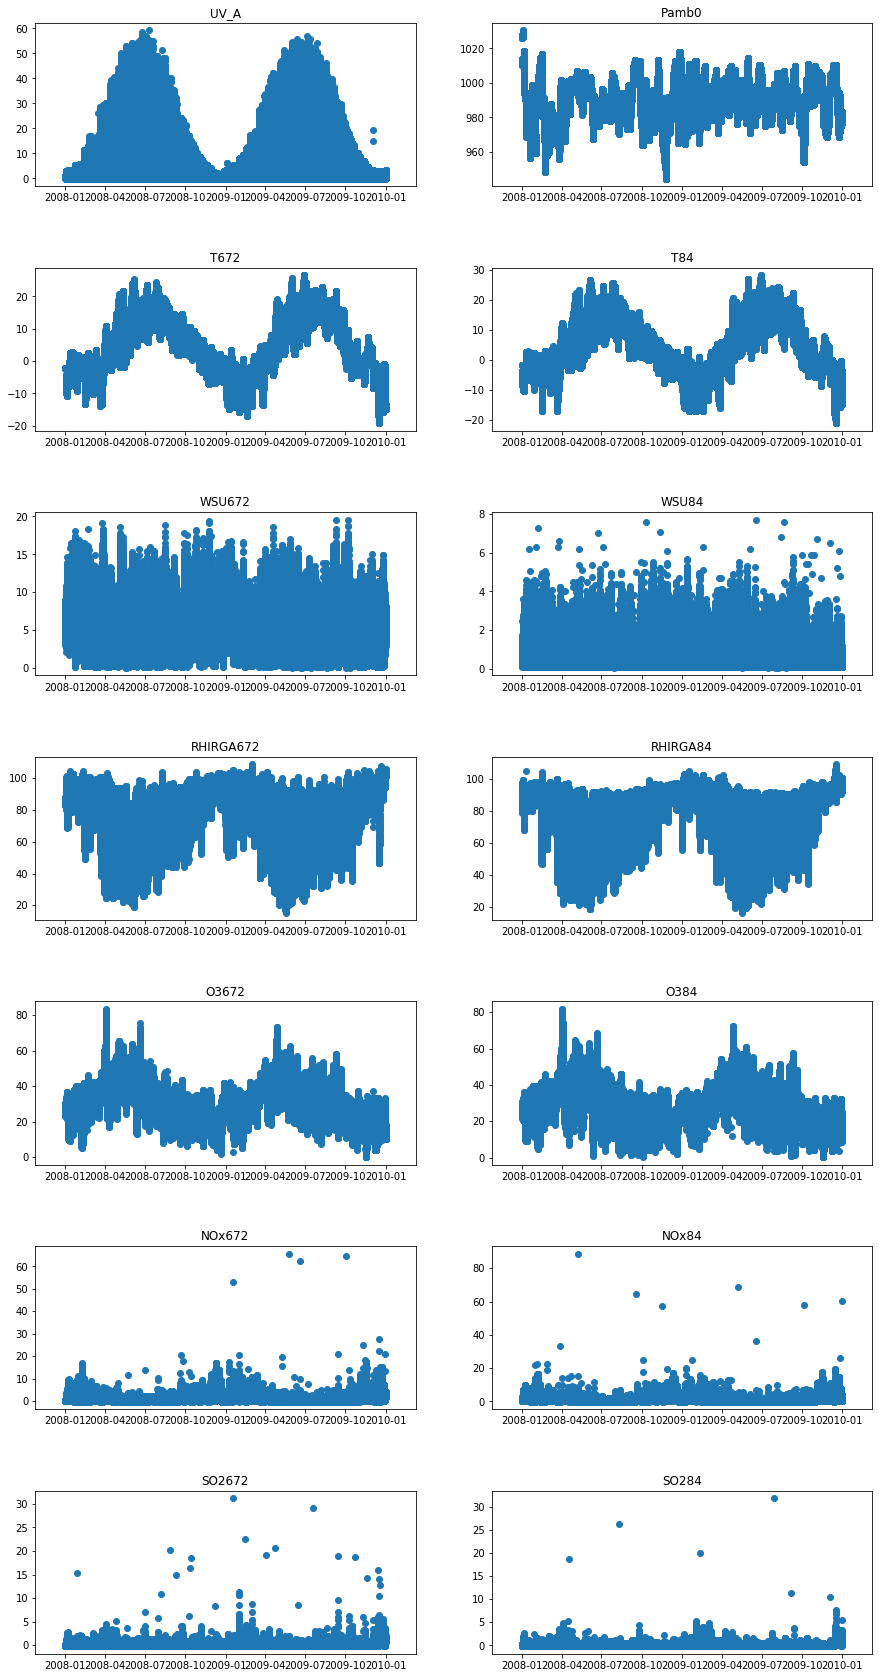

In [179]:
fig, axe = plt.subplots(7,2, figsize = (15, 30))
axe = axe.flatten()
for i in range(df.shape[1]):
    axe[i].scatter(Time, df.iloc[:,i])
    axe[i].set_title(df.columns[i])
    
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)